In [2]:
pip install scikit-learn lightgbm


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.9 MB ? eta -:--:--
   ----- ---------------------------------- 1.3/8.9 MB 5.6 MB/s eta 0:00:02
   --------------- ------------------------ 3.4/8.9 MB 7.5 MB/s eta 0:00:01
   ---------------------------- ----------- 6.3/8.9 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 8.9/8.9 MB 11.1 MB/s  0:00:01
Using cached lightgbm-4.6.0-py3-none-win_amd64.whl (1.5 MB)
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ------------------------------------

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb

df = pd.read_csv("processed_walmart.csv", parse_dates=["Date"])

df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Week,DayOfWeek,Quarter,Lag_1,Lag_2,Lag_4,Roll_Mean_4,Roll_Std_4,Store_Avg_Sales,Dept_Avg_Sales,Norm_Sales,Holiday_Before,Holiday_After
0,1,1,2011-01-04 00:00:00,20398.09,False,2011.0,1.0,1,1.0,1.0,0.00,0.00,0.00,0.0000,0.000000,21710.543621,19213.485088,0.939548,False,False
1,1,1,2012-01-06 00:00:00,16065.49,False,2012.0,1.0,1,4.0,1.0,20398.09,0.00,0.00,0.0000,0.000000,21710.543621,19213.485088,0.739986,False,False
2,1,1,2011-01-07 00:00:00,15363.50,False,2011.0,1.0,1,4.0,1.0,16065.49,20398.09,0.00,0.0000,0.000000,21710.543621,19213.485088,0.707652,False,False
3,1,1,2010-01-10 00:00:00,20094.19,False,2010.0,1.0,1,6.0,1.0,15363.50,16065.49,0.00,0.0000,0.000000,21710.543621,19213.485088,0.925550,False,False
4,1,1,2012-02-03 00:00:00,20113.03,False,2012.0,2.0,5,4.0,1.0,20094.19,15363.50,20398.09,17980.3175,2634.918025,21710.543621,19213.485088,0.926418,False,False


In [5]:
y = df['Weekly_Sales']

features = [col for col in df.columns if col not in ['Weekly_Sales', 'Date']]

X = df[features]

print("Number of features:", len(features))
X.head()


Number of features: 18


,Store,Dept,IsHoliday,Year,Month,Week,DayOfWeek,Quarter,Lag_1,Lag_2,Lag_4,Roll_Mean_4,Roll_Std_4,Store_Avg_Sales,Dept_Avg_Sales,Norm_Sales,Holiday_Before,Holiday_After
0,1,1,False,2011.0,1.0,1,1.0,1.0,0.00,0.00,0.00,0.0000,0.000000,21710.543621,19213.485088,0.939548,False,False
1,1,1,False,2012.0,1.0,1,4.0,1.0,20398.09,0.00,0.00,0.0000,0.000000,21710.543621,19213.485088,0.739986,False,False
2,1,1,False,2011.0,1.0,1,4.0,1.0,16065.49,20398.09,0.00,0.0000,0.000000,21710.543621,19213.485088,0.707652,False,False
3,1,1,False,2010.0,1.0,1,6.0,1.0,15363.50,16065.49,0.00,0.0000,0.000000,21710.543621,19213.485088,0.925550,False,False
4,1,1,False,2012.0,2.0,5,4.0,1.0,20094.19,15363.50,20398.09,17980.3175,2634.918025,21710.543621,19213.485088,0.926418,False,False


In [6]:
df = df.sort_values(by=['Date'])

train_size = 0.7
val_size = 0.2

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size/(train_size+val_size), shuffle=False
)

print(X_train.shape, X_val.shape, X_test.shape)


(295098, 18) (84315, 18) (42157, 18)


In [7]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [8]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1,
    'seed': 42
}


In [ ]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

model = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    n_estimators=1000,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),  
        log_evaluation(period=50)            
    ]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1820
[LightGBM] [Info] Number of data points in the train set: 295098, number of used features: 18
[LightGBM] [Info] Start training from score 17144.952996
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 3152.46	valid_0's l2: 9.938e+06
[100]	valid_0's rmse: 2929.59	valid_0's l2: 8.58251e+06
[150]	valid_0's rmse: 2838.11	valid_0's l2: 8.05488e+06
[200]	valid_0's rmse: 2812.24	valid_0's l2: 7.90872e+06
[250]	valid_0's rmse: 2783.02	valid_0's l2: 7.74523e+06
[300]	valid_0's rmse: 2768.01	valid_0's l2: 7.66188e+06
[350]	valid_0's rmse: 2754.63	valid_0's l2: 7.58801e+06
[400]	valid_0's rmse: 2740.95	valid_0's l2: 7.51281e+06
[450]	valid_0's rmse: 2721.83	valid_0's l2: 7.40836e+06
[500]	valid_0's rmse: 2711.

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_val_pred = model.predict(X_val)
y_val_true = np.array(y_val)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
mae = mean_absolute_error(y_val_true, y_val_pred)
r2 = r2_score(y_val_true, y_val_pred)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")
print(f"Validation R2: {r2:.4f}")


Validation RMSE: 2668.48
Validation MAE: 611.58
Validation R2: 0.9807


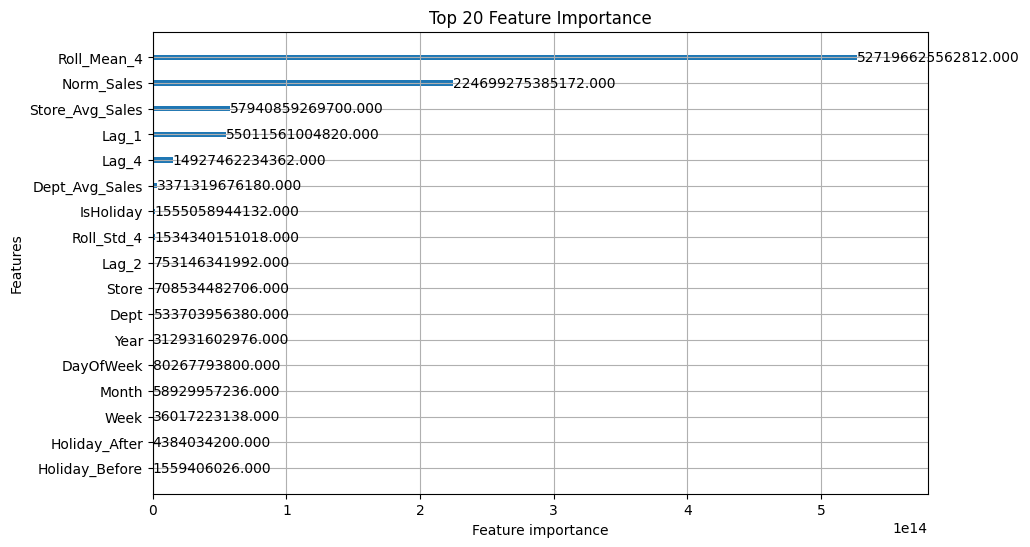

In [29]:
import matplotlib.pyplot as plt
import lightgbm as lgb

lgb.plot_importance(
    model,
    max_num_features=20,     
    importance_type='gain',   
    figsize=(10,6)
)

plt.title("Top 20 Feature Importance")
plt.show()


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


y_test_pred = model.predict(X_test)
y_test_true = np.array(y_test)

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test = r2_score(y_test_true, y_test_pred)

print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test R2: {r2_test:.4f}")


Test RMSE: 2269.54
Test MAE: 747.26
Test R2: 0.9864
